# Cluster characteristics

Generate summary characteristics of clusters at a selected resolution.

In [15]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray
import dataframe_image as dfi
from core.utils import get_cluster_names
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter

from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Lato"]

v = "v10"

regions = gpd.read_parquet("/data/uscuni-ulce/regions/cadastre_regions_hull.parquet")

In [2]:
cluster_mapping = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq"
)

In [3]:
# regional clustering load

results = []
for region_id, region_hull in regions.iterrows():
    print(region_id)

    # setup regional data
    region_clusters = pd.read_parquet(
        f"/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq",
        columns=["final_without_noise"],
    ).final_without_noise
    # region_clusters = region_clusters.map(cluster_mapping[3].to_dict())

    region_data = pd.read_parquet(
        f"/data/uscuni-ulce/processed_data/chars/primary_chars_{region_id}.parquet"
    )
    region_data = region_data.loc[region_clusters.index]

    region_data["label"] = region_clusters

    results.append(region_data)

all_data = pd.concat(results, ignore_index=True)

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [4]:
from core.utils import used_keys

new_keys = used_keys.copy()
new_keys["limLPS"] = "building structure optimised for sunlight"
new_keys["limAre"] = "sum of the largest 75 building areas in the morphotope"
new_keys["limPer"] = "sum of the largest 75 building perimeters in the morphotope"
new_keys["limLAL"] = "sum of the largest 75 axis lengths"

In [5]:
# remap to cut
all_data["label"] = all_data["label"].map(cluster_mapping[3].to_dict())

In [6]:
all_data["label"].value_counts()

label
7    43992742
5    14291481
4    13179006
8     9917621
3     7836957
1     4067711
2     2990596
6     2031919
Name: count, dtype: int64

In [7]:
## doesnt include indicator var, since that is a morphotope variable...
cluster_centres = all_data.groupby("label").mean()
cluster_centres.columns = cluster_centres.columns.map(new_keys)
table_data = cluster_centres

In [8]:
cols1 = table_data.columns[: table_data.columns.shape[0] // 2]
cols2 = table_data.columns[table_data.columns.shape[0] // 2 :]

#### get a subset of differentiating variables

In [9]:
linkage_matrix = np.load(
    f"/data/uscuni-ulce/processed_data/clusters/kmeans_linkage_{v}.npy"
)
regional_ward_morphotopes_data = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_input_data_{v}.pq"
)

FileNotFoundError: [Errno 2] No such file or directory: '/data/uscuni-ulce/processed_data/clusters/kmeans_linkage_v10.npy'

In [ ]:
from scipy.cluster.hierarchy import fcluster

final_cutoff = 1 / 4 - 0.00001
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion="distance")
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)

cinput_data = regional_ward_morphotopes_data.groupby(final_clusters).median()
total_median = regional_ward_morphotopes_data.median()


results = []
for i, row_data in cinput_data.iterrows():
    diffs = row_data - total_median
    top_diffs = ((diffs) ** 2).sort_values().iloc[-10:]
    top_diffs = diffs.loc[top_diffs.index].sort_values(ascending=False)
    results.append(top_diffs.index.values)

col_subset = np.unique(results)
col_subset.shape

#### plot tables

In [10]:
cluster_centres = all_data.groupby("label").mean()

In [11]:
col_keys = new_keys.copy()
to_drop = [
    "stcSAl",
    "stbOri",
    "stcOri",
    "stbCeA",
    "ldkAre",
    "ldkPer",
    "lskCCo",
    "lskERI",
    "lskCWA",
    "ltkOri",
    "ltkWNB",
    "likWBB",
    "likWCe",
    "licBAD",
    "misBAD",
    "ssbCCM",
    "ssbCCD",
]

for k in to_drop:
    col_keys.pop(k, None)

In [12]:
# cluster_centres['limLPS'] = [2.0] * 9 + [-4.8, 2, 2, 2, 2, -4.8, 2]
table_data = cluster_centres.loc[
    :, cluster_centres.columns[cluster_centres.columns.isin(list(col_keys.keys()))]
]
table_data.columns = [col_keys[k] for k in table_data.columns]
table_data.index = table_data.index.map(get_cluster_names(3)).values

In [13]:
cols1 = table_data.columns[: table_data.columns.shape[0] // 2]
cols2 = table_data.columns[table_data.columns.shape[0] // 2 :]

In [14]:
table = table_data.loc[:, cols1]
f = {k: "{:.2f}" for k in table_data.columns.values}
table = table.style.format(f).background_gradient(axis=0, cmap="BuGn")
table

,area of building,perimeter of building,courtyard area of building,circular compactness of building,corners of building,squareness of building,equivalent rectangular index of building,elongation of building,shared walls ratio of buildings,number of courtyards within adjacent buildings,perimeter wall length of adjacent buildings,level of building adjacency,alignment of neighbouring buildings,mean distance between neighbouring buildings,mean inter-building distance,street alignment of building,length of street segment,linearity of street segment,mean segment length within 3 steps,reached ETCs by local street network,reached total ETC area by local street network,buildings per meter of street segment,width of street profile,openness of street profile,width deviation of street profile,node degree of junction,local meshedness of street network,local proportion of 3-way intersections of street network,local proportion of 4-way intersections of street network
Incoherent Large-Scale Homogeneous Fabric,354.56,74.11,1.60,0.48,7.46,2.74,0.95,0.58,0.19,0.06,168.21,0.73,3.82,21.28,23.31,8.79,369.73,0.94,228.91,340.77,598855.41,0.10,30.78,0.64,3.93,2.85,0.10,0.71,0.13
Incoherent Large-Scale Heterogeneous Fabric,566.06,74.59,1.77,0.50,6.54,3.61,0.96,0.61,0.19,0.09,222.75,0.73,3.84,22.75,25.41,9.86,595.08,0.92,330.51,357.15,883122.56,0.09,32.19,0.74,4.13,2.74,0.08,0.71,0.11
Incoherent Small-Scale Linear Fabric,135.37,46.19,0.08,0.52,5.23,1.62,0.97,0.63,0.09,0.01,69.35,0.86,3.57,24.38,26.38,11.80,1953.26,0.91,893.69,723.53,2761810.45,0.07,31.72,0.89,4.66,2.92,0.08,0.72,0.09
Incoherent Small-Scale Sparse Fabric,142.07,47.22,0.31,0.53,5.81,1.93,0.96,0.66,0.08,0.01,65.45,0.88,4.82,30.13,32.62,10.58,747.34,0.92,516.07,356.38,1355852.33,0.07,31.25,0.84,4.54,2.72,0.08,0.72,0.08
Incoherent Small-Scale Compact Fabric,116.35,42.42,0.15,0.53,6.10,2.06,0.96,0.69,0.11,0.01,67.42,0.83,4.42,19.82,21.73,9.76,433.13,0.93,323.36,355.64,679697.40,0.14,27.57,0.67,4.68,2.73,0.08,0.71,0.08
Coherent Interconnected Fabric,207.56,59.00,1.66,0.49,7.77,4.88,0.93,0.64,0.42,2.48,662.00,0.39,3.24,7.49,10.06,5.51,171.92,0.97,130.66,460.26,305276.68,0.18,19.78,0.27,3.18,3.22,0.16,0.69,0.21
Coherent Dense Disjoint Fabric,90.71,37.71,0.06,0.54,6.16,2.17,0.96,0.69,0.20,0.01,77.23,0.73,3.36,12.26,14.06,8.04,219.45,0.93,175.12,389.29,357942.87,0.17,24.62,0.47,4.45,2.85,0.10,0.71,0.11
Coherent Dense Adjacent Fabric,105.73,41.06,0.25,0.51,6.35,3.00,0.95,0.63,0.37,0.14,181.83,0.55,2.98,9.12,11.55,7.58,189.52,0.95,149.57,433.13,311747.63,0.23,22.49,0.38,4.28,2.89,0.11,0.71,0.13


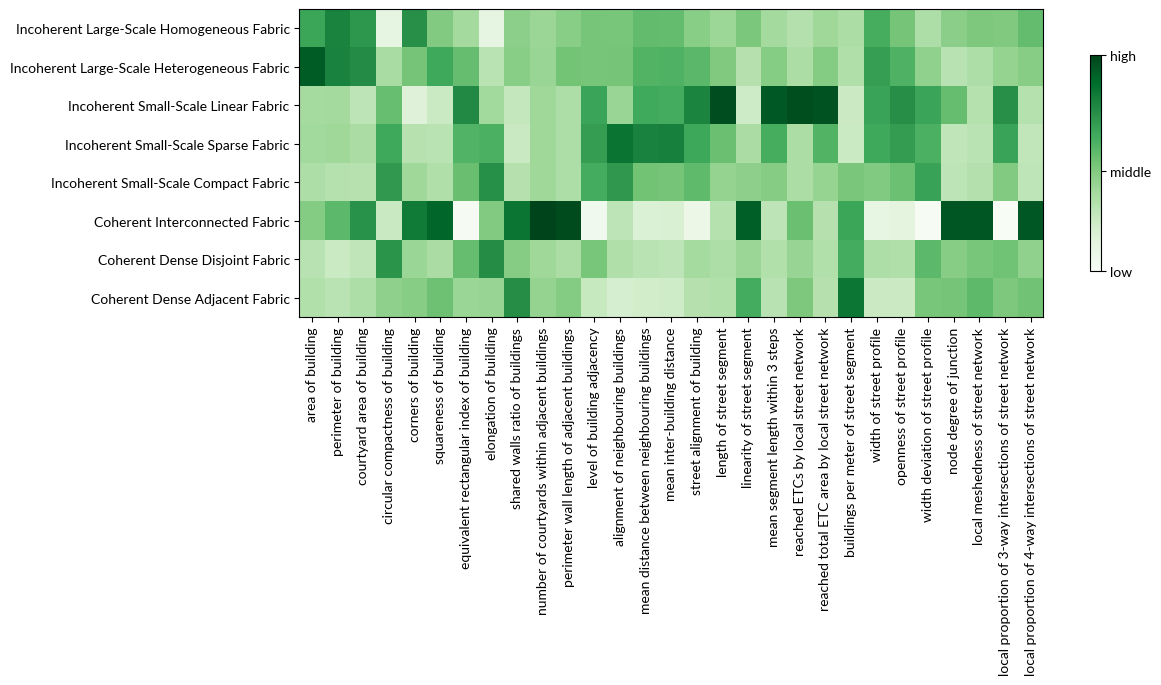

In [52]:
f, ax = plt.subplots(figsize=(12, 4))

data = table_data.loc[:, cols1]

data = (data - data.mean())/data.std()

im = ax.imshow(data, aspect="auto", cmap="Greens")
plt.colorbar(im, ticks=[data.min().min(), 0, data.max().max()], 
             format=FixedFormatter(["low", "middle", "high"]), shrink=.7)

plt.xticks(ticks=range(data.shape[1]), labels=data.columns, rotation=90)
plt.yticks(ticks=range(data.shape[0]), labels=data.index)
plt.savefig('../figs/features1.png', dpi=300, bbox_inches='tight')

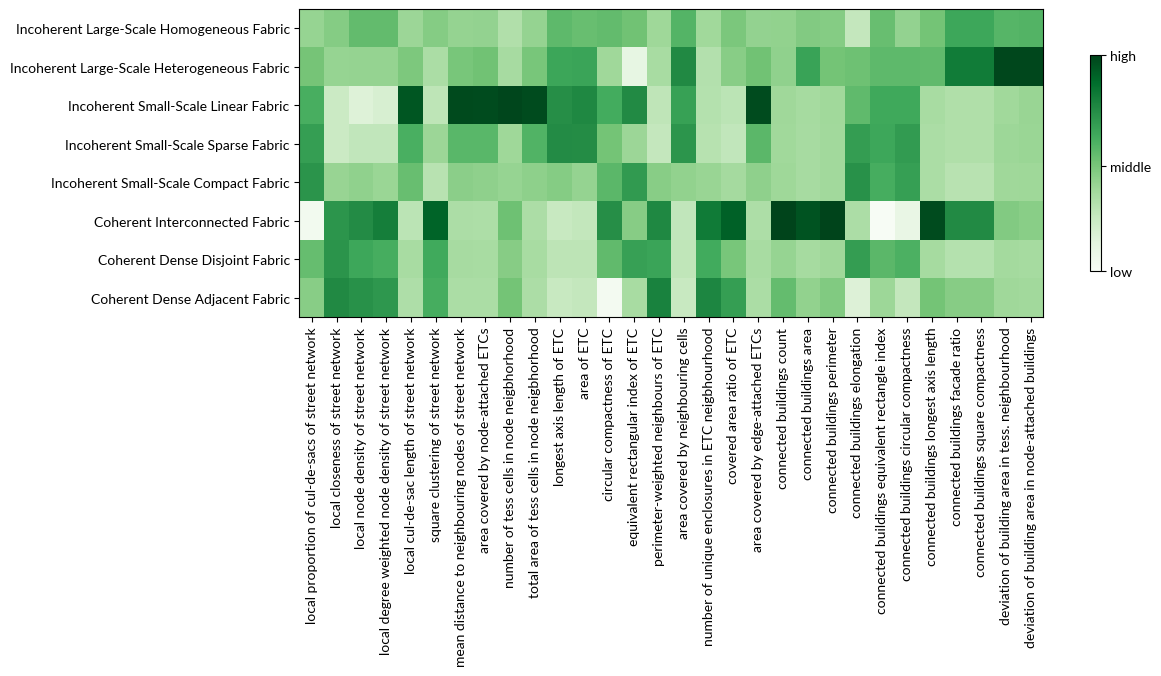

In [53]:
f, ax = plt.subplots(figsize=(12, 4))

data = table_data.loc[:, cols2]

data = (data - data.mean())/data.std()

im = ax.imshow(data, aspect="auto", cmap="Greens")
plt.colorbar(im, ticks=[data.min().min(), 0, data.max().max()], 
             format=FixedFormatter(["low", "middle", "high"]), shrink=.7)

plt.xticks(ticks=range(data.shape[1]), labels=data.columns, rotation=90)
plt.yticks(ticks=range(data.shape[0]), labels=data.index)
plt.savefig('../figs/features2.png', dpi=300, bbox_inches='tight')